In [1]:
import numpy as np
import pandas as pd
import os 
import time
import deepdish.io as dd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from utils.inference import SVI
import utils.models as m
import utils.datasets as d

# Load and Prepare Data

In [2]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [3]:
X.shape

(83680, 160)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [5]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
train = d.H_alphaSequences(X_train, y_train)
test = d.H_alphaSequences(X_test, y_test)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size=512, shuffle=True)

# Model setup

In [8]:
vae = m.CBN_VAE(original_dim=160, latent_dim=15)

In [9]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [10]:
svi = SVI(
        vae_model=vae,
        optimizer=optimizer,
        loss_function="GaussianNLL",
        scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70], gamma=0.1),
        tensorboard=True,
        model_name = "CNN-VAE_ReLU_NLL_lr-{1e-3, 1e-4}_bs-512",
        verbose=True
        )

cuda:0


In [11]:
lh = svi(epochs=200, train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [1/199], average_loss:34.2544, validation_loss:-51.3212
Epoch [2/199], average_loss:-63.8484, validation_loss:-84.0471
Epoch [3/199], average_loss:-67.9500, validation_loss:-73.2850
Epoch [4/199], average_loss:-78.3654, validation_loss:-114.8831
Epoch [5/199], average_loss:-89.6887, validation_loss:-128.2337
Epoch [6/199], average_loss:-95.5516, validation_loss:-113.6817
Epoch [7/199], average_loss:-112.4967, validation_loss:-120.0548
Epoch [8/199], average_loss:-107.7839, validation_loss:-142.4580
Epoch [9/199], average_loss:-110.3969, validation_loss:-122.3549
Epoch [10/199], average_loss:-112.5804, validation_loss:-141.6702
Epoch [11/199], average_loss:-115.3707, validation_loss:-146.5102
Epoch [12/199], average_loss:-105.9213, validation_loss:-78.6715
Epoch [13/199], average_loss:-109.6888, validation_loss:-134.8792
Epoch [14/199], average_loss:-119.3391, validation_loss:-152.7359
Epoch [15/199], average_loss:-112.6088, validation_loss:-121.8320
Epoch [16/199], average_loss:-

Epoch [126/199], average_loss:-218.0728, validation_loss:-226.2056
Epoch [127/199], average_loss:-218.4256, validation_loss:-222.4938
Epoch [128/199], average_loss:-218.8659, validation_loss:-221.7544
Epoch [129/199], average_loss:-218.6014, validation_loss:-223.7132
Epoch [130/199], average_loss:-214.1175, validation_loss:-223.5178
Epoch [131/199], average_loss:-220.6818, validation_loss:-225.6460
Epoch [132/199], average_loss:-218.5014, validation_loss:-222.2830
Epoch [133/199], average_loss:-219.1027, validation_loss:-225.9547
Epoch [134/199], average_loss:-218.6654, validation_loss:-225.0970
Epoch [135/199], average_loss:-217.4441, validation_loss:-201.1029
Epoch [136/199], average_loss:-218.1866, validation_loss:-221.2508
Epoch [137/199], average_loss:-220.0465, validation_loss:-225.9119
Epoch [138/199], average_loss:-221.6461, validation_loss:-221.2605
Epoch [139/199], average_loss:-216.3144, validation_loss:-223.2092
Epoch [140/199], average_loss:-220.1994, validation_loss:-227.

# Evaluation

In [16]:
#torch.save(svi.model, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-200.pt")
#torch.save(svi.optimizer, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-200_optimizer.pt")

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CBN_VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon

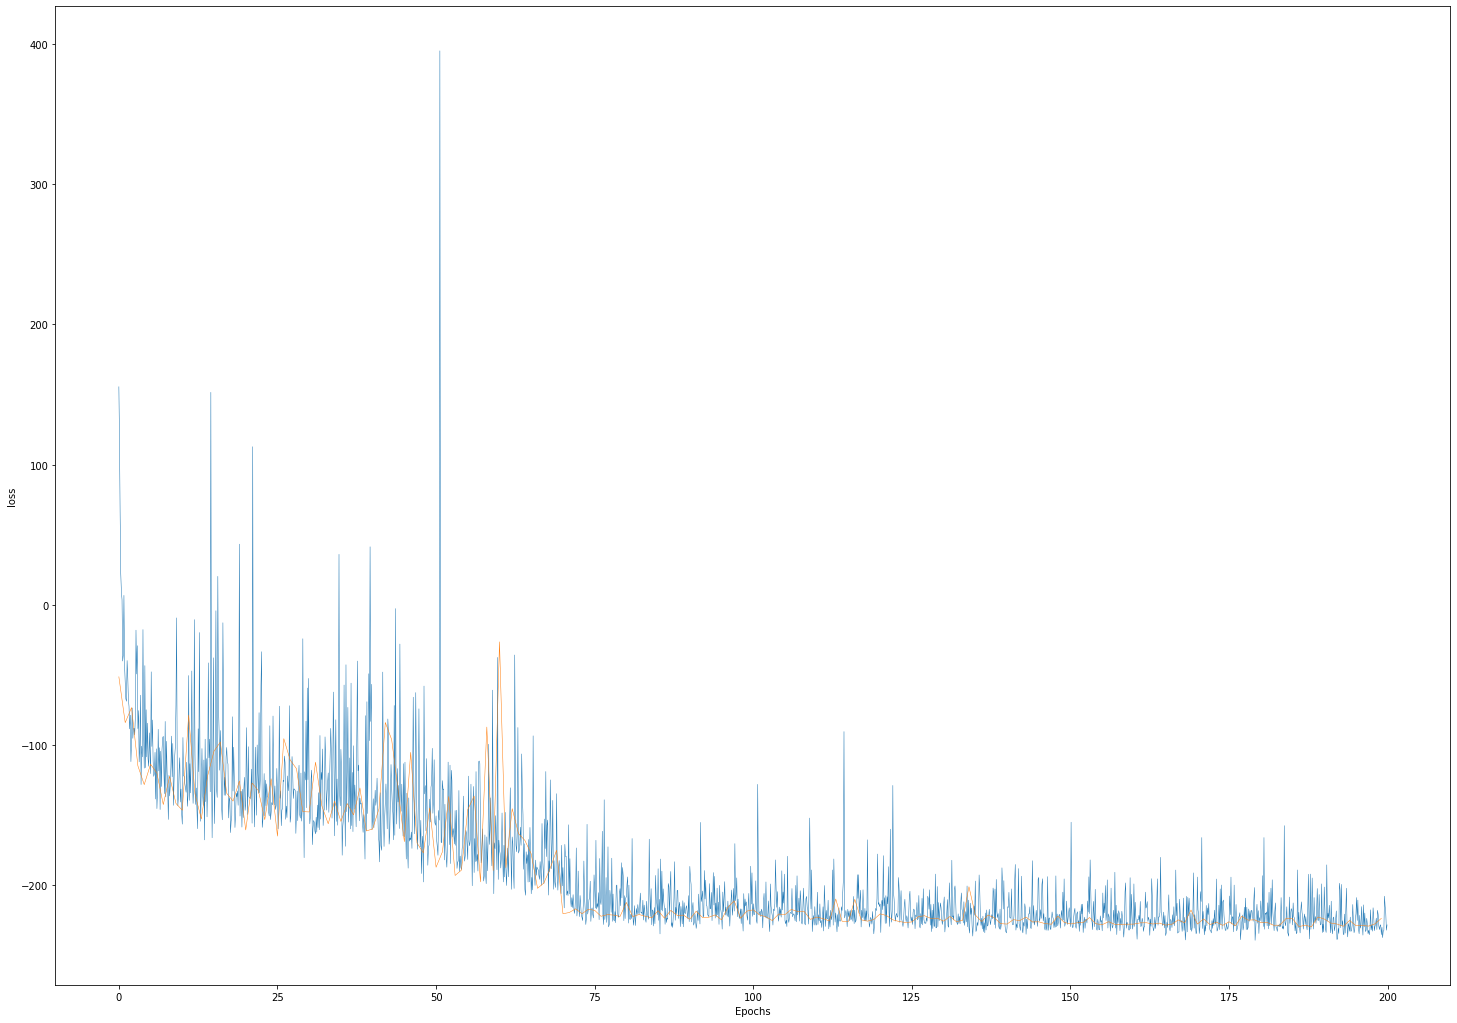

In [12]:
from utils.inference import plot_loss
plot_loss(svi)

cuda:0


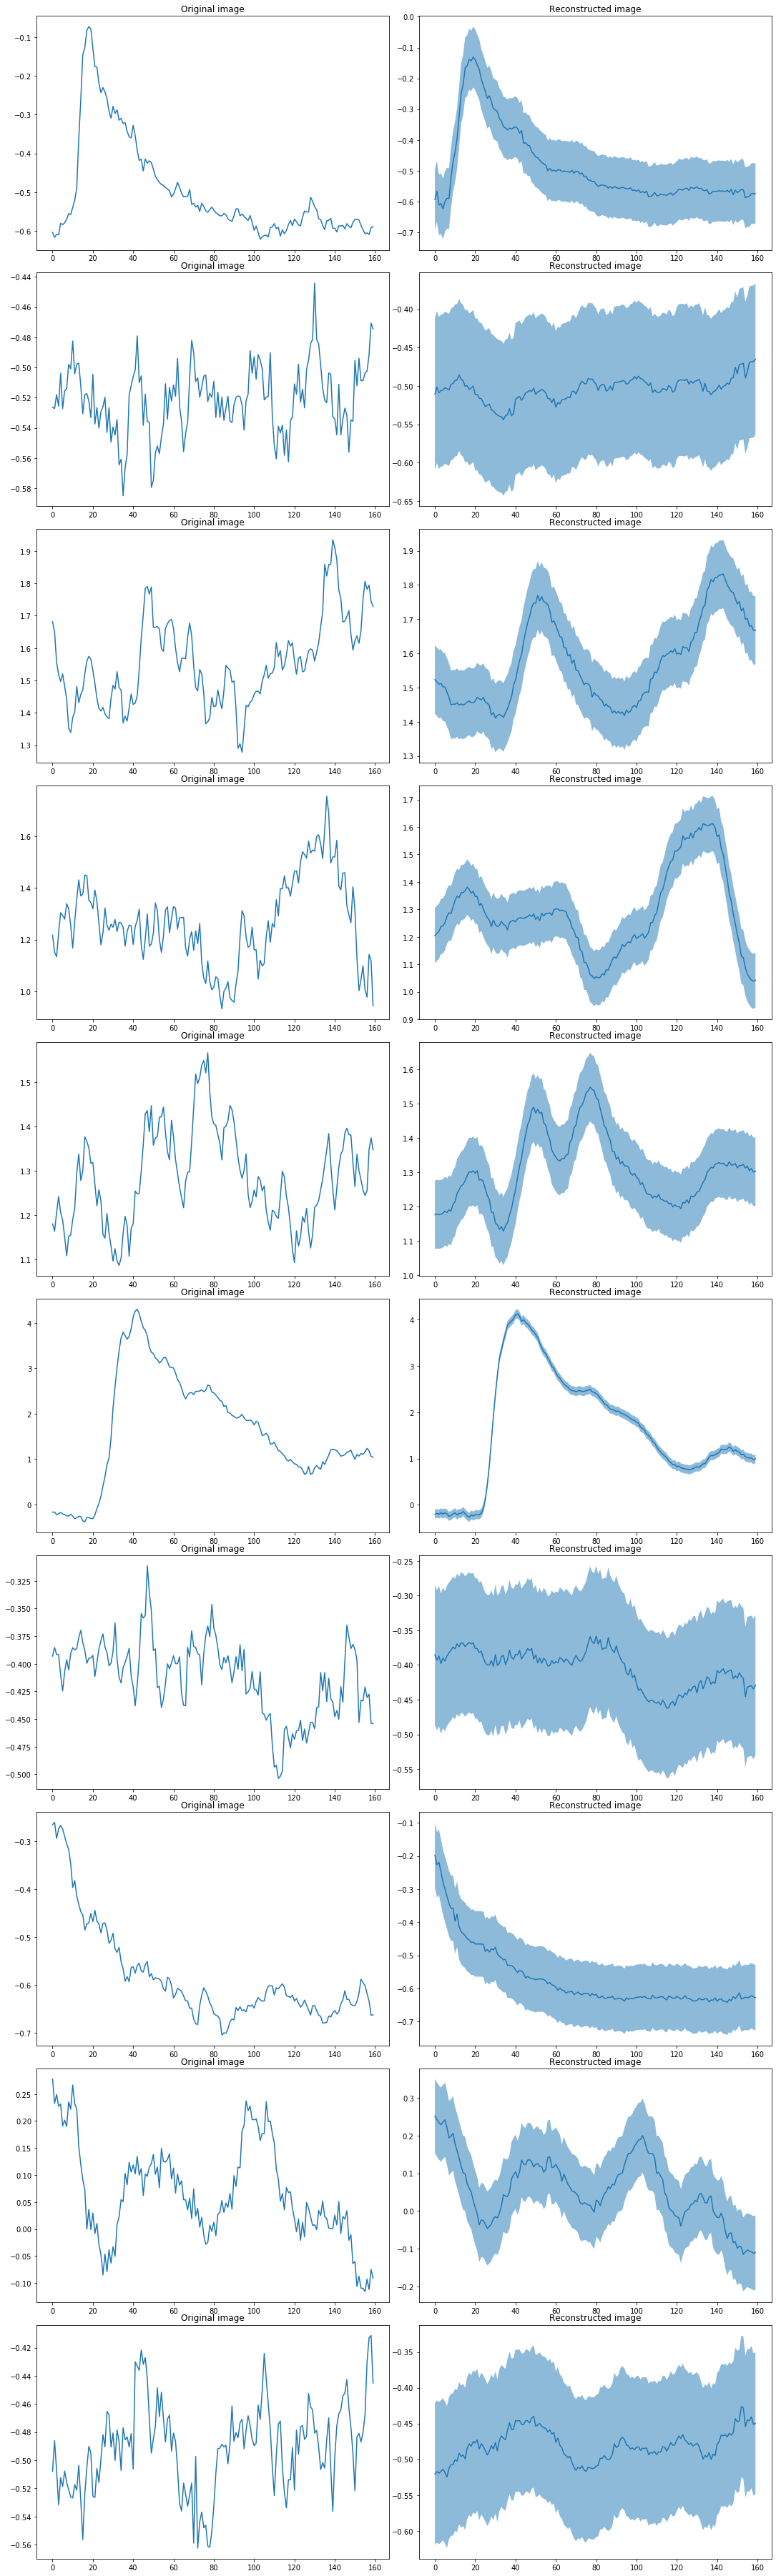

In [15]:
# epoch 100
print(svi.device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(svi.device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

cuda:0


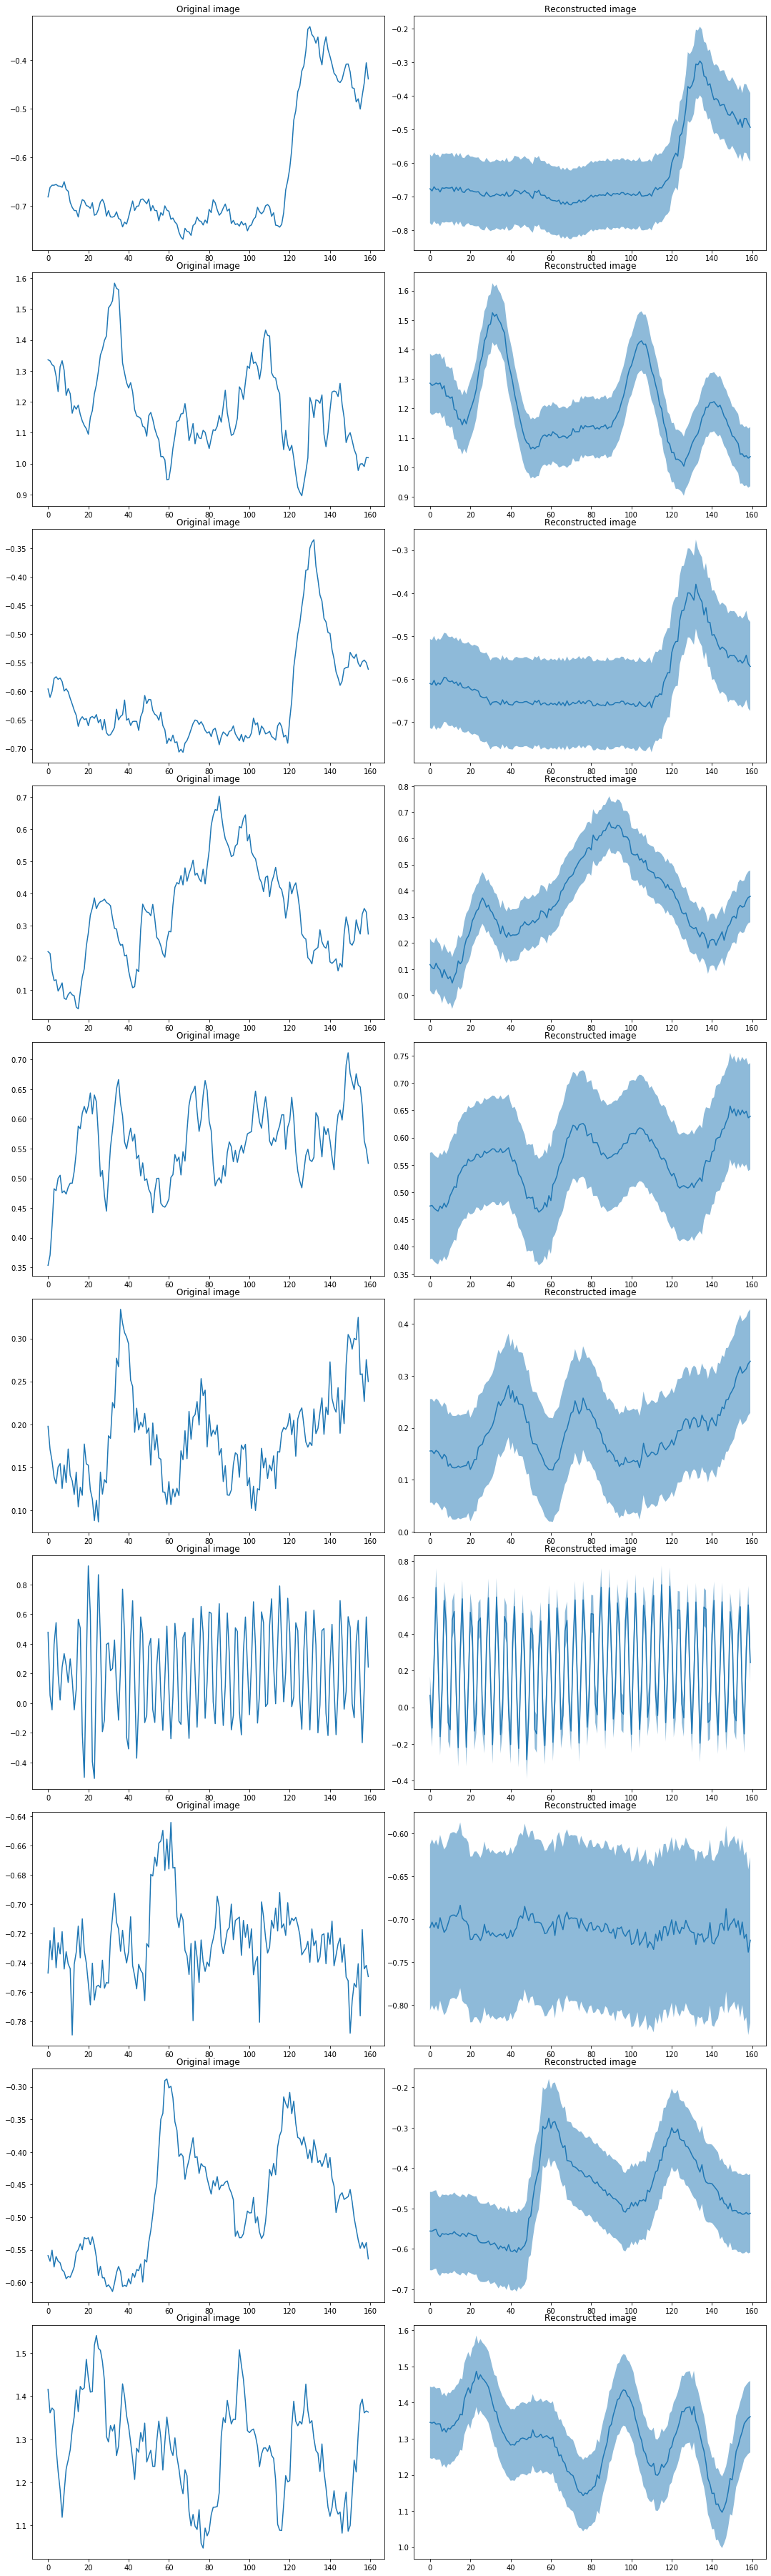

In [17]:
# epoch 100
print(svi.device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(svi.device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

In [18]:
lh = svi(epochs=range(200,300), train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [201/299], average_loss:-225.0665, validation_loss:-222.6430
Epoch [202/299], average_loss:-224.9214, validation_loss:-230.3007
Epoch [203/299], average_loss:-224.1294, validation_loss:-219.4447
Epoch [204/299], average_loss:-225.3976, validation_loss:-229.9672
Epoch [205/299], average_loss:-224.7727, validation_loss:-224.4634
Epoch [206/299], average_loss:-226.7112, validation_loss:-228.0606
Epoch [207/299], average_loss:-224.3412, validation_loss:-222.7748
Epoch [208/299], average_loss:-225.4598, validation_loss:-230.2244
Epoch [209/299], average_loss:-222.2583, validation_loss:-227.6434
Epoch [210/299], average_loss:-224.9912, validation_loss:-229.0688
Epoch [211/299], average_loss:-224.4237, validation_loss:-227.9118
Epoch [212/299], average_loss:-225.5215, validation_loss:-227.3151
Epoch [213/299], average_loss:-226.1737, validation_loss:-230.0405
Epoch [214/299], average_loss:-227.9638, validation_loss:-228.1888
Epoch [215/299], average_loss:-226.8367, validation_loss:-228.

cuda:0


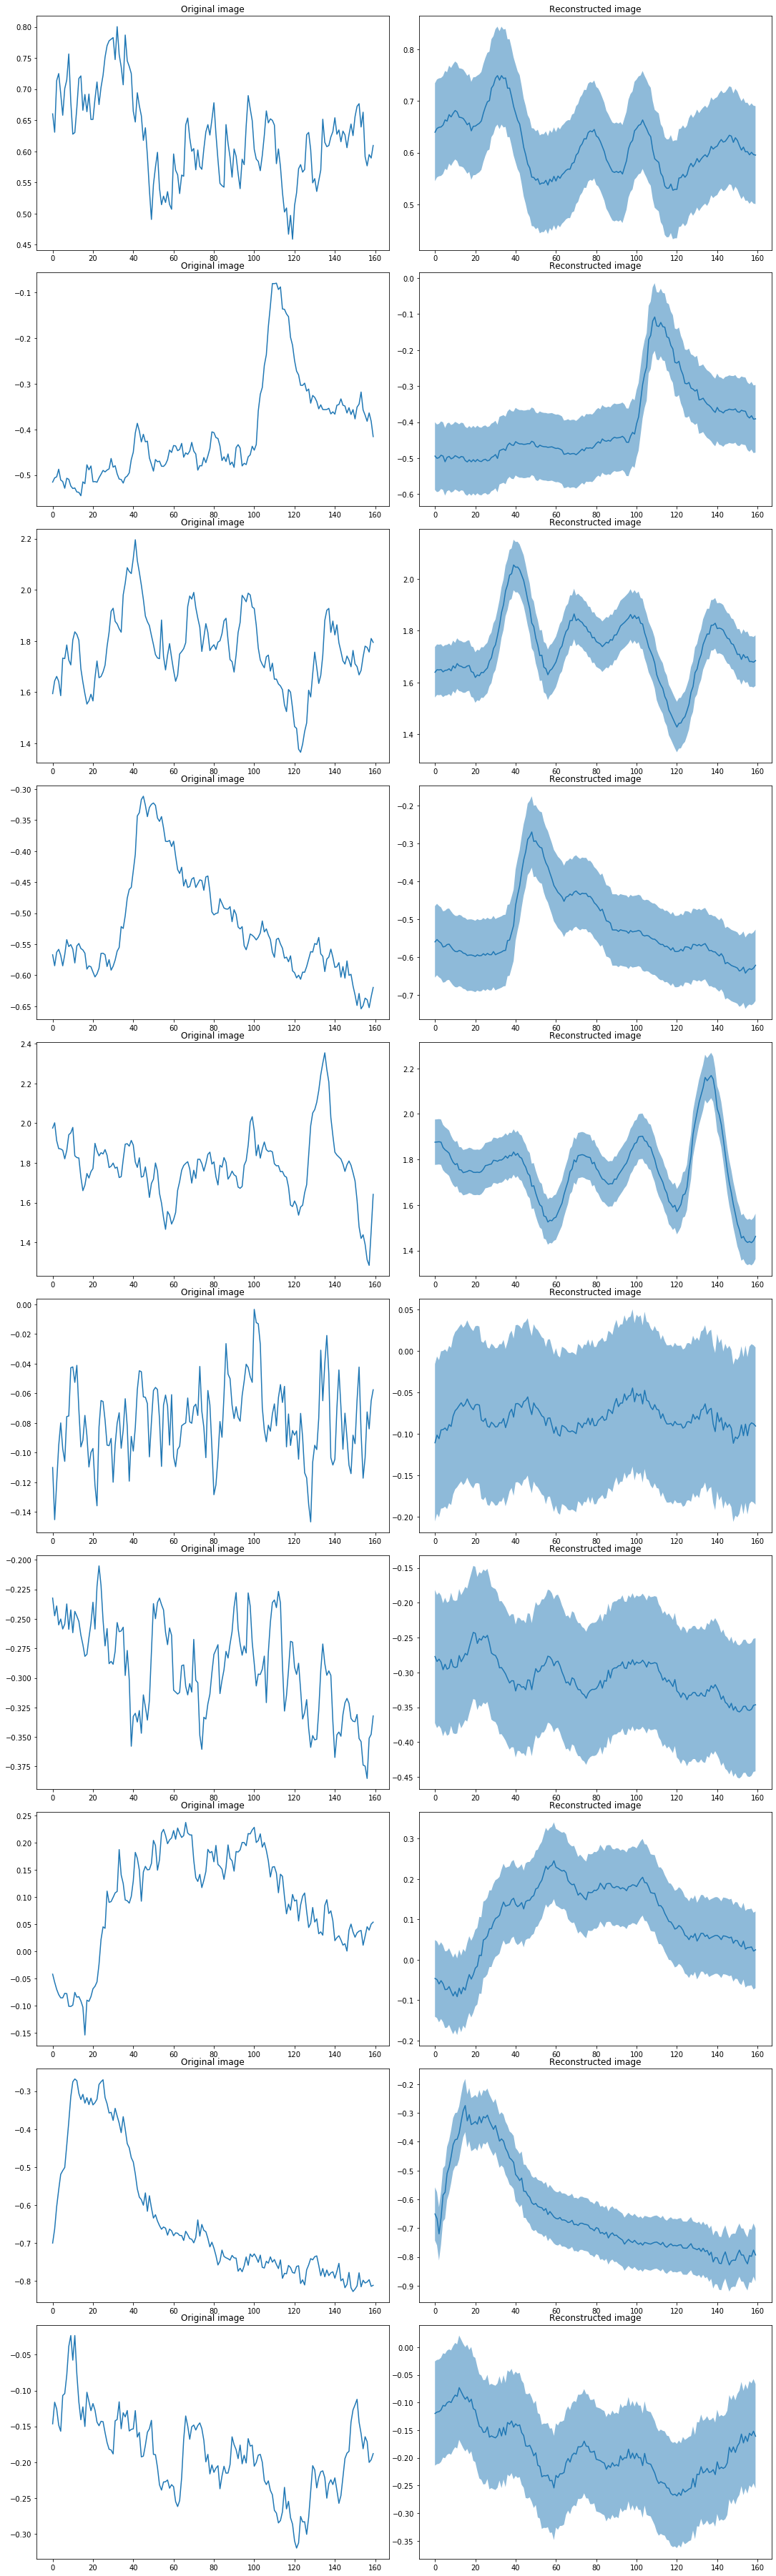

In [19]:
# epoch 100
print(svi.device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(svi.device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

In [20]:
#torch.save(svi.model, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.pt")
#torch.save(svi.optimizer, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300_optimizer.pt")

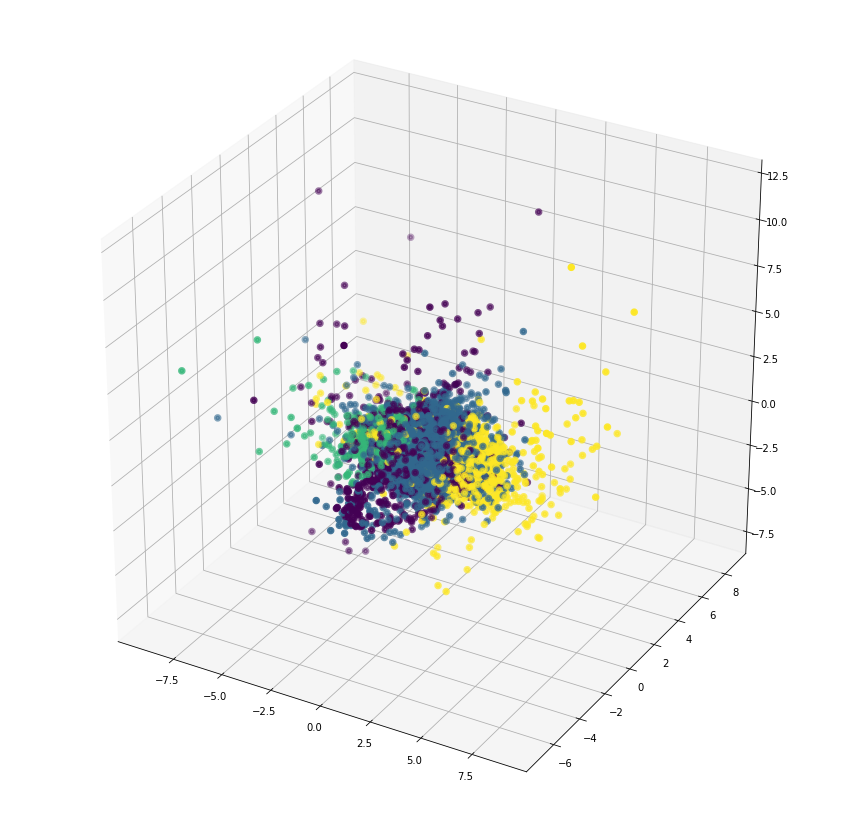

In [24]:
# epoch 200
X_1, cl = test.X, test.y
Z_hat, mu, sigma = svi.model.encoder(X_1.to(svi.device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Z_hat[:,0], Z_hat[:,1], Z_hat[:,2], c=cl, lw=3)
sc = ax.scatter(mu[:,0], mu[:,1], mu[:,2], c=cl, lw=3)

In [11]:
X.shape

(83680, 160)

In [8]:
mod = torch.load("models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.pt")

In [9]:
mod.eval()
Z_hat1, mu1, sigma1 = mod.encoder(torch.tensor(X_train[:42340,:]).float().cuda()) #.view(-1,28*28)
mu1 = mu1.cpu().detach().numpy()

In [10]:
mod.eval()
_, mu2, _ = mod.encoder(torch.tensor(X_train[42340:,:]).float().cuda()) #.view(-1,28*28)
mu2 = mu2.cpu().detach().numpy()

In [11]:
mod.eval()
_, mu_t, _ = mod.encoder(torch.tensor(X_test).float().cuda()) #.view(-1,28*28)
mu_t = mu_t.cpu().detach().numpy()

In [12]:
mu1.shape

(42340, 15)

In [13]:
mu2.shape

(24604, 15)

In [14]:
mu = np.vstack((mu1,mu2))
mu.shape

(66944, 15)

In [15]:
#np.save("data/enocoded_data_train_CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.npy", mu)

In [16]:
#np.save("data/enocoded_data_test_CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.npy", mu_t)